In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow import keras
import keras
import matplotlib.pyplot as plt
from vis.visualization import visualize_saliency
from vis.visualization import get_num_filters
from vis.visualization import visualize_saliency_init
from vis.visualization import visualize_saliency_run
from vis.utils import utils
from tqdm import tqdm
from scipy.stats import describe
from scipy.stats import iqr
from scipy.stats import variation
import os
import imageio

/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel

# 1. Loading Data 

## Read dataset

In [2]:
data = tf.keras.datasets.mnist

In [3]:
(trainX, trainY),(testX, testY) = data.load_data()

In [4]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

In [5]:
trainY = keras.utils.to_categorical(trainY, 10)
testY = keras.utils.to_categorical(testY, 10)

In [6]:
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [7]:
print(trainX.shape)

(60000, 28, 28, 1)


In [8]:
describe(testX,axis=None)

DescribeResult(nobs=7840000, minmax=(0.0, 1.0), mean=0.13251467, variance=0.09639801, skewness=2.1285581588745117, kurtosis=2.809452489039299)

# Training

## Code for training

In [9]:
#Creates Sequential model using Keras
#Number of nodes is the same as number of features (different number of nodes were tried but it did not
#affect validation accuracy significantly)
lenet = keras.Sequential([
                            #Input layer:
                            keras.layers.Conv2D(20, 5, padding="same", input_shape=[28,28,1], use_bias=True),
                            #Hidden Layers:
                            keras.layers.Activation(activation="relu"),
                            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                            keras.layers.Conv2D(50, 5, padding="same"),
                            keras.layers.Activation(activation="relu"),
                            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                            keras.layers.Flatten(),
                            keras.layers.Dense(500),
                            keras.layers.Activation(activation="relu"),
                            keras.layers.Dense(10, name='vis',use_bias=True),
                            #Output layer
                            keras.layers.Activation(activation="softmax"),
                        ])

In [10]:
#lenets = [keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet)]

In [11]:
classifier_number = 5
lenets = [keras.models.clone_model(lenet)]
for i in range(1,classifier_number):
    lenets.append(keras.models.clone_model(lenet))

In [12]:
#Compiles sequential model
#Using learning rate 0.01
#Loss function will be categorical crossentropy
lenet.compile(
                optimizer=keras.optimizers.SGD(lr=0.01),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy']
                )
#Trains network over a number of epochs and evaluates network agains validation data
#after each epoch
lenetEpochHistory = lenet.fit(trainX, trainY, epochs = 5, validation_data = (testX, testY))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 16s 272us/step - loss: 0.4133 - acc: 0.8797 - val_loss: 0.1312 - val_acc: 0.9595
Epoch 2/5
60000/60000 [==============================] - 12s 200us/step - loss: 0.1100 - acc: 0.9668 - val_loss: 0.0966 - val_acc: 0.9693
Epoch 3/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.0765 - acc: 0.9760 - val_loss: 0.0610 - val_acc: 0.9801
Epoch 4/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.0616 - acc: 0.9813 - val_loss: 0.0512 - val_acc: 0.9838
Epoch 5/5
60000/60000 [==============================] - 12s 204us/step - loss: 0.0520 - acc: 0.9838 - val_loss: 0.0436 - val_acc: 0.9856


In [13]:
#Compiles sequential model
#Using learning rate 0.01
#Loss function will be categorical crossentropy
for model in lenets:
    model.compile(
                    optimizer=keras.optimizers.SGD(lr=0.01),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy']
                    )
#Trains network over a number of epochs and evaluates network agains validation data
#after each epoch
for model in lenets:
    model.fit(trainX, trainY, epochs = 5, validation_data = (testX, testY))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 212us/step - loss: 0.4177 - acc: 0.8834 - val_loss: 0.1204 - val_acc: 0.9610
Epoch 2/5
60000/60000 [==============================] - 12s 205us/step - loss: 0.1043 - acc: 0.9681 - val_loss: 0.0817 - val_acc: 0.9745
Epoch 3/5
60000/60000 [==============================] - 12s 202us/step - loss: 0.0727 - acc: 0.9778 - val_loss: 0.0557 - val_acc: 0.9821
Epoch 4/5
60000/60000 [==============================] - 12s 199us/step - loss: 0.0577 - acc: 0.9822 - val_loss: 0.0491 - val_acc: 0.9834
Epoch 5/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.0488 - acc: 0.9849 - val_loss: 0.0440 - val_acc: 0.9864
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 209us/step - loss: 0.4360 - acc: 0.8797 - val_loss: 0.1323 - val_acc: 0.9591
Epoch 2/5
60000/60000 [==============================] - 12s 203us/step 

# General Evaluation

In [14]:
#Predicting Label:

print(np.argmax(lenet.predict(testX)[100]))
print(np.argmax(testY[100]))

6
6


10000/10000 [==============================] - 1s 78us/step
Lenet accuracy:  0.9856
Lenet loss:  0.04356702570673078


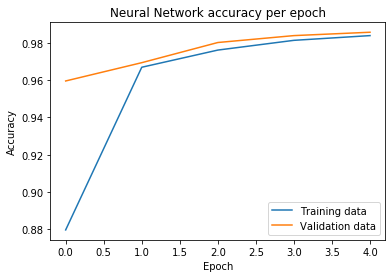

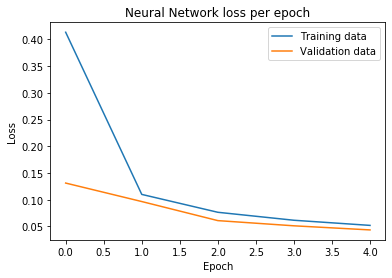

In [15]:
#Get accuracy for lenet
sequentialLoss, sequentialAccuracy = lenet.evaluate(testX, testY)
print('Lenet accuracy: ', sequentialAccuracy)
print('Lenet loss: ', sequentialLoss)

plt.plot(lenetEpochHistory.history['acc'])
plt.plot(lenetEpochHistory.history['val_acc'])
plt.title('Neural Network accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training data', 'Validation data'])
plt.show()

plt.plot(lenetEpochHistory.history['loss'])
plt.plot(lenetEpochHistory.history['val_loss'])
plt.title('Neural Network loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training data', 'Validation data'])
plt.show()

In [16]:
correct = 0
for i in range(0,len(testX)):
    if (get_ensemble_output(lenets,testX[i],10) == np.argmax(testY[i])):
        correct = correct + 1
        

NameError: name 'get_ensemble_output' is not defined

In [ ]:
print(correct)
print(len(testX))

# Saliency

In [16]:
#This line outputs the layer_idx that the saliency is meant to be extracted from. (Usually the output layer pre-activation)
utils.find_layer_idx(lenet, 'vis')

9

In [17]:
#Check if that layer is correct by checking if the number of nodes matches the number of outputs
get_num_filters(lenet.layers[9])

10

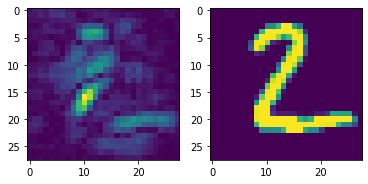

In [18]:
#Check if the saliency map is working for the singular network
input_idx = 1
fig, ax = plt.subplots(nrows=1, ncols=2)
saliency_map = visualize_saliency(model = lenet,layer_idx = 9, filter_indices = np.argmax(testY[input_idx]), seed_input = testX[input_idx])
ax[0].imshow(saliency_map.reshape(28,28),interpolation='nearest')
ax[1].imshow(testX[input_idx].reshape(28,28))
plt.show()

In [19]:
# Get optimisers for each network's output node to speed up saliency processing
optimisers = []
classifiers = lenets
for i in range(0,len(classifiers)):
    classifier_optmisers = []
    for j in range(0,10):
        opt = visualize_saliency_init(classifiers[i],9,filter_indices=j)
        classifier_optmisers.append(opt)
    optimisers.append(classifier_optmisers)
        

In [20]:
#Function to calculate ensemble outputs (for series of inputs) using mean of outputs
def get_ensenmble_outputs(classifiers,classifier_inputs,number_of_outputs):
    predictions = np.zeros((np.size(classifier_inputs, axis=0), np.size(number_of_outputs)))
    for classifier in classifiers:
        predictions = predictions + classifier.predict(classifier_inputs)
    prediction_average = predictions / classifier_number
    outputs = np.apply_along_axis(np.argmax, axis=1, arr=prediction_average)
    return(outputs)
        

In [21]:
#Function to calculate ensemble output (for one input) using mean of outputs
def get_ensemble_output(classifiers,classifier_input,number_of_outputs):
    predictions = np.zeros(np.size(number_of_outputs))
    for classifier in classifiers:
        predictions = predictions + classifier.predict(np.expand_dims(classifier_input,axis=0))
    prediction_average = predictions / classifier_number
    output = np.argmax(prediction_average)
    return(output)
        

In [22]:
get_ensemble_output(lenets,testX[100],10)

6

In [23]:
correct = 0
for i in range(0,len(testX)):
    if (get_ensemble_output(lenets,testX[i],10) == np.argmax(testY[i])):
        correct = correct + 1
        

In [24]:
print(correct)
print(len(testX))

9886
10000


In [25]:
# Function to generate multiple saliency maps for each input

# If doing this over multiple inputs at a time, it is faster to go over multiple inputs
# with the same classifier and then doing the same for the different classifiers. This is 
# because switching optimisers is computationally expensive.

def generate_saliency_maps_for_one_input(classifiers,classifier_input,optimisers,visualised_layer):
    output_node = get_ensemble_output(classifiers,classifier_input,len(optimisers))
    saliency_maps = np.zeros((len(classifiers),classifier_input.shape[0],classifier_input.shape[1]))
    for i in range(0,len(classifiers)):
        saliency_maps[i] = visualize_saliency_run(model = classifiers[i],layer_idx = visualised_layer, opt = optimisers[i][output_node], seed_input = classifier_input)
    return(saliency_maps)
    

In [26]:
#Function to visualise the multiple saliency maps
def visualize_saliency_maps(classifier_input,saliency_maps):
    fig, ax = plt.subplots(nrows=1, ncols=len(saliency_maps)+1, figsize = (15,15))
    i = 1
    for s_map in saliency_maps:
        ax[i].imshow(s_map)
        i = i+1
    ax[0].imshow(classifier_input)
    plt.show()

In [27]:
# Compute difference of saliency maps using coefficient of variation
def generate_uncertainty_map_with_CV(saliency_maps):
    return(variation(saliency_maps,axis=0))

In [28]:
# Compute difference of saliency maps using quartile coefficient of dispersion
def generate_uncertainty_map_with_QCoD(saliency_maps,rng):
    lower_quantile, higher_quantile = rng
    lower_quantile = lower_quantile/100
    higher_quantile = higher_quantile/100
    return(iqr(saliency_maps,axis=0,rng=rng)/(np.quantile(saliency_maps,lower_quantile,axis=0)
                                             + np.quantile(saliency_maps,higher_quantile,axis=0)))

In [29]:
# Wrapper function to arrive at uncertainty output using classifiers and input
def calculate_uncertainty(classifiers,classifier_input,optimisers,visualised_layer):
    
    saliency_maps = generate_saliency_maps_for_one_input(classifiers = classifiers,
                                  classifier_input = classifier_input,
                                  optimisers = optimisers,
                                  visualised_layer = visualised_layer)
    
    uncertainty_map = generate_uncertainty_map_with_CV(saliency_maps)
    
    return(np.average(uncertainty_map))


In [30]:
# Compute difference of saliency maps
def calculate_CV_uncertainty_with_maps(saliency_maps):
    return(np.mean(generate_uncertainty_map_with_CV(saliency_maps)))

In [31]:
# Compute difference of saliency maps
def calculate_QCoD_uncertainty_with_maps(saliency_maps,rng):
    return(np.mean(generate_uncertainty_map_with_QCoD(saliency_maps,rng=rng)))

In [32]:
def generate_saliency_maps_for_multiple_inputs(classifier,classifier_inputs,classifier_outputs,
                                               classifier_optimisers,visualised_layer):
    
    saliency_maps = []
    for input_idx in tqdm(range(0,np.size(classifier_inputs,axis=0))):
        classifier_input = classifier_inputs[input_idx]
        output_node = classifier_outputs[input_idx]
        saliency_maps.append(visualize_saliency_run(model = classifier,
                                                    layer_idx = 9, 
                                                    opt = classifier_optimisers[output_node],   
                                                    seed_input = classifier_input))
    return(saliency_maps)


In [33]:
def generate_ensemble_saliency_maps_for_multiple_inputs(classifiers,
                                                        classifier_inputs,classifier_outputs,
                                                        optimisers,visualised_layer):
    saliency_maps = []
    for classifier_idx in range(0,len(classifiers)):
        saliency_maps.append(generate_saliency_maps_for_multiple_inputs(
                                classifiers[classifier_idx],
                                classifier_inputs,
                                classifier_outputs,
                                optimisers[classifier_idx],
                                9))
    return(saliency_maps)
    

# MNIST

In [34]:
MNIST_ensemble_predicted_outputs = get_ensenmble_outputs(lenets, testX,10)

In [35]:
# Generate saliency maps examples
input_idx = 1
maps = generate_saliency_maps_for_one_input(classifiers = lenets,
                                            classifier_input = testX[input_idx],
                                            optimisers = optimisers,
                                            visualised_layer = 9)

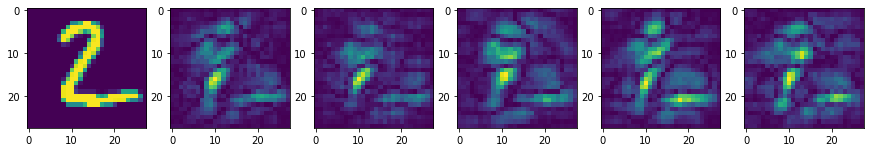

In [36]:
# Visualise saliency maps examples
visualize_saliency_maps(classifier_input = testX[input_idx].reshape(28,28),
                        saliency_maps = maps)

In [37]:
for mapx in maps:
    print(describe(mapx,axis=None))

DescribeResult(nobs=784, minmax=(0.0, 0.9999998211860657), mean=0.12462816291861029, variance=0.02245210967153496, skewness=2.2093026504600504, kurtosis=5.888378774644584)
DescribeResult(nobs=784, minmax=(0.0, 0.9999998211860657), mean=0.11768951452390587, variance=0.018974922920137752, skewness=2.554826983488466, kurtosis=8.551589695792433)
DescribeResult(nobs=784, minmax=(0.0, 0.9999998211860657), mean=0.15467507515725684, variance=0.02769861457067722, skewness=1.917547549281095, kurtosis=4.067012223181022)
DescribeResult(nobs=784, minmax=(0.0, 0.9999997615814209), mean=0.16074069807488128, variance=0.03426539801186234, skewness=1.8313403249684308, kurtosis=3.1646571729918866)
DescribeResult(nobs=784, minmax=(0.0, 0.9999997615814209), mean=0.16010673029130867, variance=0.029212431393582376, skewness=2.0212178389991995, kurtosis=4.632924158472827)


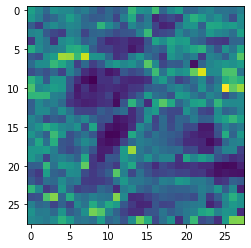

In [38]:
# Visualise uncertainty map example
x = 40
y = 60
#uncertainty_map = generate_uncertainty_map_with_QCoD(maps,rng=(x,y))
#uncertainty_map = generate_uncertainty_map_with_QCoD(maps,rng=(20,100))
uncertainty_map = generate_uncertainty_map_with_CV(maps)
plt.imshow(uncertainty_map)
plt.show()

In [39]:
describe(uncertainty_map,axis=None)

DescribeResult(nobs=784, minmax=(0.045773850931073695, 1.4611245263115076), mean=0.5547083556100642, variance=0.060902004639881165, skewness=0.34536990219421143, kurtosis=-0.05873453412968166)

In [40]:
# Compute the average difference value for each pixel (uncertainty)
np.average(uncertainty_map)

0.5547083556100642

In [41]:
# Generating example using wrapper function
input_idx = 4
uncertainty = calculate_uncertainty(classifiers = lenets,
                              classifier_input = testX[input_idx],
                              optimisers = optimisers,
                              visualised_layer = 9)
print(uncertainty)

0.5457161464386482


In [42]:
MNIST_saliency_maps = generate_ensemble_saliency_maps_for_multiple_inputs(lenets,testX,MNIST_ensemble_predicted_outputs,optimisers,9)

100%|██████████| 10000/10000 [00:35<00:00, 279.13it/s]


In [43]:
MNIST_saliency_maps = np.swapaxes(MNIST_saliency_maps,0,1)

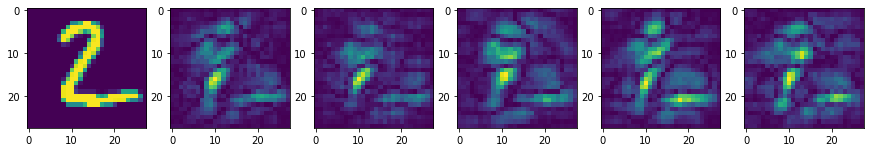

In [44]:
visualize_saliency_maps(testX[1].reshape(28,28),MNIST_saliency_maps[1])

In [45]:
MNIST_uncertainties = np.zeros(np.size(MNIST_saliency_maps,axis=0))
for i in range(0,np.size(MNIST_saliency_maps, axis=0)):
#    MNIST_uncertainties[i] = calculate_QCoD_uncertainty_with_maps(MNIST_saliency_maps[i],rng=(x,y))
    MNIST_uncertainties[i] = calculate_CV_uncertainty_with_maps(MNIST_saliency_maps[i])

In [46]:
MNIST_uncertainties[0]

0.5640475749969482

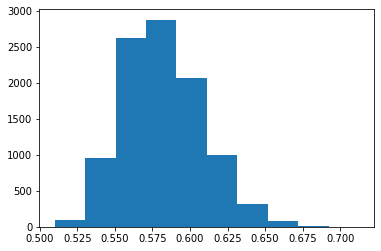

In [81]:
plt.hist(MNIST_uncertainties)
plt.savefig("MNIST_uncertainties.png")
plt.show()

In [48]:
describe(MNIST_uncertainties)

DescribeResult(nobs=10000, minmax=(0.5100147724151611, 0.7124846577644348), mean=0.582133004438877, variance=0.0006911767169252696, skewness=0.4148659067238674, kurtosis=0.042392523577952534)

# Not-MNIST

In [49]:
folders = ['./data/notMNIST_small/A',
           './data/notMNIST_small/B',
           './data/notMNIST_small/C',
           './data/notMNIST_small/D',
           './data/notMNIST_small/E',
           './data/notMNIST_small/F',
           './data/notMNIST_small/G',
           './data/notMNIST_small/H',
           './data/notMNIST_small/I',
           './data/notMNIST_small/J']

In [50]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

In [51]:
# Source: https://www.ritchieng.com/machine-learning/deep-learning/tensorflow/notmnist/
def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype("float32") - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

In [52]:
letters = []
for folder in folders:
    letters.extend(load_letter(folder,1))
letters = np.asarray(letters)

./data/notMNIST_small/A
Could not read: ./data/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : Could not find a format to read the specified file in single-image mode - it's ok, skipping.
Full dataset tensor: (1872, 28, 28)
Mean: -0.1326264
Standard deviation: 0.4451279
./data/notMNIST_small/B
Full dataset tensor: (1873, 28, 28)
Mean: 0.005356083
Standard deviation: 0.45711535
./data/notMNIST_small/C
Full dataset tensor: (1873, 28, 28)
Mean: -0.14152053
Standard deviation: 0.44269025
./data/notMNIST_small/D
Full dataset tensor: (1873, 28, 28)
Mean: -0.04921665
Standard deviation: 0.45975894
./data/notMNIST_small/E
Full dataset tensor: (1873, 28, 28)
Mean: -0.05991476
Standard deviation: 0.4573496
./data/notMNIST_small/F
Could not read: ./data/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png : Could not find a format to read the specified file in single-image mode - it's ok, skipping.
Full dataset tensor: (1872, 28, 28)
Mean: -0.11818528
Standard deviation: 

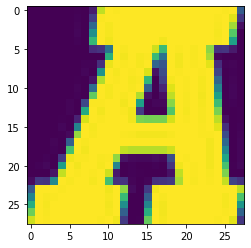

In [53]:
plt.imshow(letters[0])
plt.show()

In [54]:
letters = letters.reshape((letters.shape[0],28,28,1))

In [55]:
#letter = letter.astype("float32") / 255.0
letters = letters + 0.5

In [56]:
describe(letters[0],axis=None)

DescribeResult(nobs=784, minmax=(0.0, 1.0), mean=0.61207485, variance=0.2098257, skewness=-0.4595169723033905, kurtosis=-1.7017732787937214)

In [57]:
NotMNIST_ensemble_predicted_outputs = get_ensenmble_outputs(lenets, letters,10)

In [58]:
NotMNIST_saliency_maps = generate_ensemble_saliency_maps_for_multiple_inputs(lenets,letters,NotMNIST_ensemble_predicted_outputs,optimisers,9)

100%|██████████| 18724/18724 [01:04<00:00, 289.20it/s]


In [59]:
NotMNIST_saliency_maps = np.swapaxes(NotMNIST_saliency_maps,0,1)

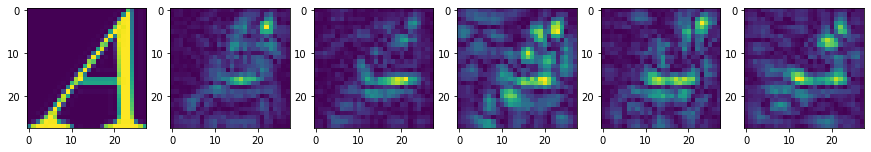

In [60]:
visualize_saliency_maps(letters[1].reshape(28,28),NotMNIST_saliency_maps[1])

In [61]:
get_ensemble_output(lenets,letters[1],10)

4

In [62]:
for mapx in NotMNIST_saliency_maps[1]:
    print(describe(mapx,axis=None))

DescribeResult(nobs=784, minmax=(0.0, 0.9999998), mean=0.12984255, variance=0.018014852, skewness=2.0338943004608154, kurtosis=5.892443089035801)
DescribeResult(nobs=784, minmax=(0.0, 0.9999998), mean=0.11329658, variance=0.019127037, skewness=2.7356491088867188, kurtosis=9.72240236563852)
DescribeResult(nobs=784, minmax=(0.0, 0.9999997), mean=0.21916242, variance=0.035333607, skewness=1.4822829961776733, kurtosis=2.3480028657149283)
DescribeResult(nobs=784, minmax=(0.0, 0.9999997), mean=0.16597281, variance=0.029990755, skewness=1.9018752574920654, kurtosis=3.880712705792387)
DescribeResult(nobs=784, minmax=(0.0, 0.99999976), mean=0.1644755, variance=0.02702483, skewness=2.03708815574646, kurtosis=4.6361790220988945)


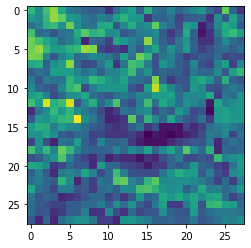

In [63]:
# Visualise uncertainty map example
#uncertainty_map = generate_uncertainty_map_with_QCoD(NotMNIST_saliency_maps[1],rng=(x,y))
#uncertainty_map = generate_uncertainty_map_with_QCoD(NotMNIST_saliency_maps[1],rng=(0,75))
uncertainty_map = generate_uncertainty_map_with_CV(NotMNIST_saliency_maps[1])
plt.imshow(uncertainty_map)
plt.show()

In [64]:
describe(uncertainty_map,axis=None)

DescribeResult(nobs=784, minmax=(0.09594042, 1.516196), mean=0.6582772, variance=0.06072313, skewness=0.33533284068107605, kurtosis=-0.13126902585721245)

In [65]:
NotMNIST_uncertainties = np.zeros(np.size(NotMNIST_saliency_maps,axis=0))
for i in range(0,np.size(NotMNIST_saliency_maps, axis=0)):
#    NotMNIST_uncertainties[i] = calculate_QCoD_uncertainty_with_maps(NotMNIST_saliency_maps[i],rng=(x,y))
    NotMNIST_uncertainties[i] = calculate_CV_uncertainty_with_maps(NotMNIST_saliency_maps[i])

In [66]:
NotMNIST_uncertainties[6]

0.5894339680671692

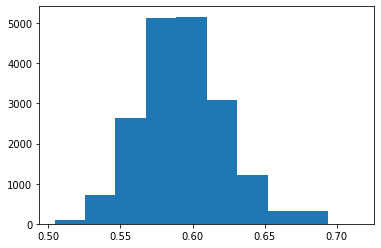

In [80]:
plt.hist(NotMNIST_uncertainties)
plt.show()
plt.savefig("NotMNIST_uncertainties.png")

In [68]:
describe(NotMNIST_uncertainties)

DescribeResult(nobs=18724, minmax=(0.5043039321899414, 0.7153803706169128), mean=0.5933714406634467, variance=0.0008637831733013427, skewness=0.3938931048971207, kurtosis=0.38273042476397023)

# Misc.

In [69]:
#This prints out the pre-activation outputs for the output layer (for curiosity)
intermediate_layer_model = keras.Model(inputs=lenet.input,
                                 outputs=lenet.get_layer("vis").output)
intermediate_output = intermediate_layer_model.predict(testX)[input_idx]
print(max(intermediate_output))
print(lenet.predict(testX)[input_idx])

12.552584
[9.8936255e-07 5.0203812e-07 1.0328033e-07 2.1560825e-07 9.9661475e-01
 4.9325578e-08 1.2631250e-05 3.9570899e-05 7.8043206e-07 3.3305725e-03]


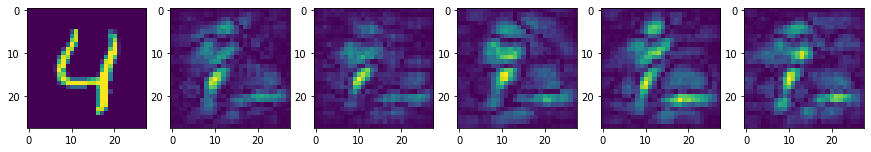

In [70]:
# Visualise saliency maps examples
visualize_saliency_maps(classifier_input = testX[input_idx].reshape(28,28),
                        saliency_maps = maps)

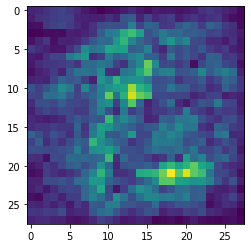

In [71]:
# This is what happens if we don't normalise the pixels' standard deviation
plt.imshow(np.std(maps,axis=0))
plt.show()

In [72]:
#Output images that were misclassified by the singular classifier
idx = 0
for i in lenet.predict(testX):
    if (np.argmax(i) != np.argmax(testY[idx])):
        print(idx)
    idx = idx + 1

247
259
321
340
445
495
582
583
613
619
659
684
720
760
924
947
1014
1039
1112
1114
1182
1226
1247
1319
1378
1393
1414
1522
1530
1621
1678
1681
1709
1878
1901
1984
2018
2035
2098
2109
2130
2135
2182
2272
2293
2387
2414
2462
2488
2654
2896
2939
2953
3073
3333
3422
3503
3520
3534
3549
3558
3597
3767
3796
3808
3811
3893
3906
3985
4075
4078
4163
4176
4224
4248
4256
4265
4360
4497
4500
4536
4578
4639
4761
4807
4823
4860
4880
5331
5457
5600
5642
5654
5842
5887
5937
5955
5973
5982
5997
6011
6023
6035
6045
6059
6166
6559
6571
6572
6576
6597
6651
6783
7434
7812
7899
7928
7990
8094
8325
8408
9009
9015
9024
9280
9587
9634
9642
9664
9669
9679
9692
9726
9729
9749
9768
9770
9779
9792
9811
9839
9856
9904
9982


In [73]:
MNIST_deviations = np.zeros(np.size(MNIST_saliency_maps,axis=0))
for i in range(0,np.size(MNIST_saliency_maps,axis = 0) -1):
    MNIST_deviations[i] = np.mean(np.std(MNIST_saliency_maps[i], axis = 0))

In [74]:
MNIST_deviations[6]

0.059934742748737335

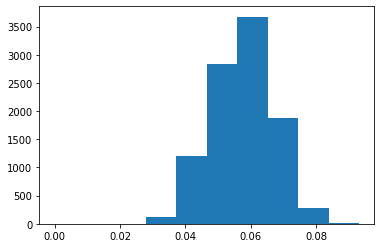

In [75]:
plt.hist(MNIST_deviations)
plt.show()

In [76]:
describe(MNIST_deviations)

DescribeResult(nobs=10000, minmax=(0.0, 0.09312409162521362), mean=0.057646200833655896, variance=8.72560339732055e-05, skewness=-0.03983001365877041, kurtosis=-0.17727832761291573)